In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.core.debugger import set_trace


## 파라미터 설정

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [5]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':20,
    'test_magnification':20,
}

In [6]:
pth_name=f"/data/pthfile/{CFG['train_magnification']}X_e{CFG['EPOCHS']}.pth"
train_data_path = f"/data/PDA_mask_img/{CFG['train_magnification']}X/**/*.png"
test_data_path = f"/data/PDA_mask_img/{CFG['test_magnification']}X/**/*.png"
output_name = f"{CFG['train_magnification']}_{CFG['test_magnification']}_{CFG['EPOCHS']}"
output_path = f"/data/output/output_{output_name}"

print(f"pth_name:{pth_name}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")
print(f"output_path:{output_path}")

pth_name:/data/pthfile/20X_e10.pth
train_data_path:/data/PDA_mask_img/20X/**/*.png
test_data_path:/data/PDA_mask_img/20X/**/*.png
output_path:/data/output/output_20_20_10


In [7]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [8]:
train_path_list = sorted(glob.glob(train_data_path))
train_path_list[:10]

['/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=51

In [9]:
test_path_list = sorted(glob.glob(test_data_path))
test_path_list[:10]

['/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=51

In [10]:
# train data path
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:10]

['/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12989,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-0001

In [11]:
train_img_path[:10]

['/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12989,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=13254,w=518,h=518].png']

In [12]:
# test data path
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:10]

['/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12989,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-0001

In [13]:
test_img_path[:10]

['/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12989,w=518,h=518].png',
 '/data/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=13254,w=518,h=518].png']

In [14]:
annotation = cv2.imread(train_mask_path[0])
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

In [15]:
image = cv2.imread(train_img_path[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)


In [16]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, type, img_transform = None, mask_transform = None):
        self.images = img_path
        self.annotations = mask_path
        
        n_samples =  len(self.images)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.images = np.array(self.images)[idxs]
        self.annotations = np.array(self.annotations)[idxs]
        
        # train or validation or test
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_val = self.images[int(0.8 * len(self.images)):int(0.9 * len(self.images))]
        self.X_test = self.images[int(0.9 * len(self.images)):]

        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_val = self.annotations[int(0.8 * len(self.annotations)):int(0.9 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.9 * len(self.annotations)):]

        self.type = type
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        if self.type == 'train':
            return len(self.X_train) # 학습용 데이터셋 길이
        elif self.type == 'validation':
            return len(self.X_val) # validation 데이터셋 길이
        else:
            return len(self.X_test) # 평가용 데이터셋 길이
        
    
    def __getitem__(self, i):
        if self.type == 'train':  # 학습용 데이터
            X_train = Image.open(self.X_train[i])
            X_train = self.img_transform(X_train)
            Y_train = Image.open(self.Y_train[i]).convert('L')
            Y_train = self.mask_transform(Y_train)
            return X_train, Y_train
        
        elif self.type == 'validation':  # validation 데이터
            X_val = Image.open(self.X_val[i])
            X_val = self.img_transform(X_val)
            Y_val = Image.open(self.Y_val[i]).convert('L')
            Y_val = self.mask_transform(Y_val)
            return X_val, Y_val
        
        else:  # 평가용 데이터
            X_test = Image.open(self.X_test[i])
            X_test = self.img_transform(X_test)
            Y_test = Image.open(self.Y_test[i]).convert('L')
            Y_test = self.mask_transform(Y_test)
            return X_test, Y_test

In [17]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

## 데이터 불러오기

In [18]:
mask_transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                    ToTensor()])


In [19]:
img_transform = {
    'train' : Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD']),
                      RandomHorizontalFlip()]),
    'val' : Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD'])]),
    'test' : Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD'])])
}

In [20]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          mask_transform = mask_transform,
                          img_transform=img_transform['train'],
                          type = 'train')

val_set = CustomDataset(img_path = train_img_path,
                         mask_path= train_mask_path,
                         mask_transform = mask_transform,
                         img_transform=img_transform['val'],
                         type = 'validation')
# 테스트 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path=test_mask_path,
                         mask_transform = mask_transform,
                         img_transform=img_transform['test'],
                         type = 'test')

In [21]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
val_loader = DataLoader(val_set, batch_size = CFG["BATCH_SIZE"])
test_loader = DataLoader(test_set, batch_size = CFG["BATCH_SIZE"])

In [22]:
print(f"train_data : {len(train_set)} / val_data : {len(val_set)} / test_data : {len(test_set)}")

train_data : 3514 / val_data : 439 / test_data : 440


## 학습

In [24]:
# 학습 파라미터
model = UNet(num_classes=1).to(device)
model = nn.DataParallel(model)
optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = nn.BCEWithLogitsLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [26]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [27]:
loss_meter = AverageMeter()
score_meter = AverageMeter()

In [28]:
def validation(model, criterion, val_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(val_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())

        val_loss_mean = loss_meter.avg
        val_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    return val_loss_mean, val_score_mean

In [29]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler, device):
    best_score = 0
    best_model = None
    model.train()
    for epoch in range(CFG["EPOCHS"]):
        try:
            for img, label in tqdm(train_loader):
                optimizer.zero_grad()
                out = model(img.to(device))
                out = torch.squeeze(out)
                pred = torch.ge(out.sigmoid(), 0.5).float()
                label = torch.squeeze(label).to(device)
                score = dice_score(pred, label)
                loss = criterion(out, label.type(torch.FloatTensor).to(device))

                loss_meter.update(loss.item())
                score_meter.update(score.item())

                loss.backward()
                optimizer.step()
                
            train_loss_mean = loss_meter.avg
            train_score_mean = score_meter.avg
            loss_meter.reset()
            score_meter.reset()
            val_loss, val_score = validation(model, criterion, val_loader, device)

            print(f"epoch{epoch+1}: Train_loss:{train_loss_mean} Train_score:{train_score_mean} Val_loss:{val_loss} Val_score:{val_score}")
            '''
            if scheduler is not None:
                scheduler.step(val_score)
            '''            
            if best_score < val_score:
                best_score = val_score
                best_model = model
    
        except KeyboardInterrupt:
            best_model = model
        
    return best_model

## Run

In [30]:
infer_model = train(model, criterion, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch1: Train_loss:0.47268335277383977 Train_score:0.5026913530045466 Val_loss:0.3086324121270861 Val_score:0.8397057397024972


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch2: Train_loss:0.5779764619740573 Train_score:0.33770843817090446 Val_loss:0.47807806730270386 Val_score:0.6233872771263123


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch3: Train_loss:0.5192367672920227 Train_score:0.5982669575647874 Val_loss:0.47662157246044706 Val_score:0.739301187651498


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch4: Train_loss:0.4883386086333882 Train_score:0.6316331511194055 Val_loss:0.39689333949770245 Val_score:0.7078736850193569


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch5: Train_loss:0.45090231787074697 Train_score:0.6572225294329903 Val_loss:0.34681677392550875 Val_score:0.7887183342661176


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch6: Train_loss:0.44359159794720737 Train_score:0.6690144419670105 Val_loss:0.3493160137108394 Val_score:0.8087422592299325


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch7: Train_loss:0.41027083830399946 Train_score:0.6967440030791543 Val_loss:0.4800897794110434 Val_score:0.3600083738565445


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch8: Train_loss:0.42659125273877924 Train_score:0.6885590656237168 Val_loss:0.2938037897859301 Val_score:0.8156664030892509


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch9: Train_loss:0.3984603237022053 Train_score:0.7110427141189575 Val_loss:0.29348213757787434 Val_score:0.8195342932428632


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch10: Train_loss:0.39094034379178827 Train_score:0.7156881841746243 Val_loss:0.31046953797340393 Val_score:0.8254500542368207


## Test

In [31]:
def Test(model, criterion, test_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(test_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())
    
        test_loss_mean = loss_meter.avg
        test_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    
    return test_loss_mean, test_score_mean

In [32]:
test_loss, test_score = Test(infer_model, criterion, test_loader, device)
print(f"test_loss: {test_loss}, test_score: {test_score}")

  0%|          | 0/7 [00:00<?, ?it/s]

test_loss: 0.29454305342265535, test_score: 0.8290474670273917


## 결과 저장

In [37]:
# 모델 저장
torch.save(infer_model.state_dict(), pth_name)

In [34]:
def denormalize(tensor, mean=CFG["MEAN"], std=CFG["STD"]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [35]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'

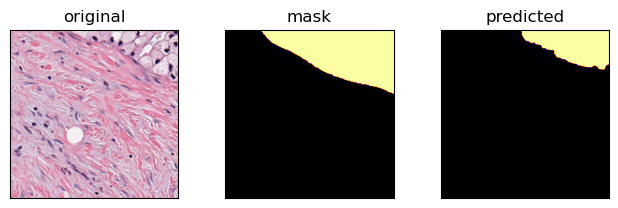

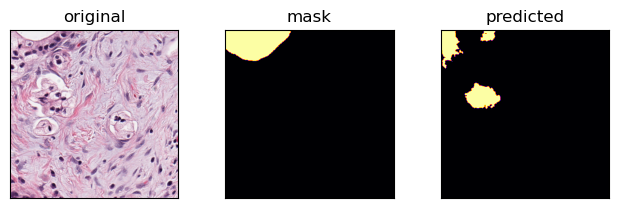

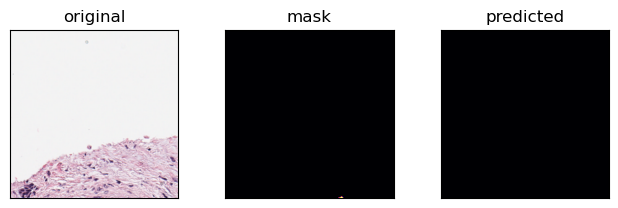

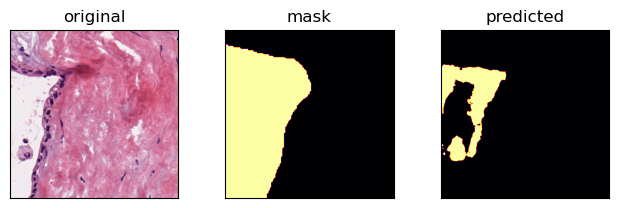

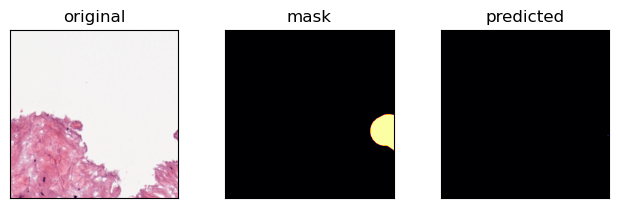

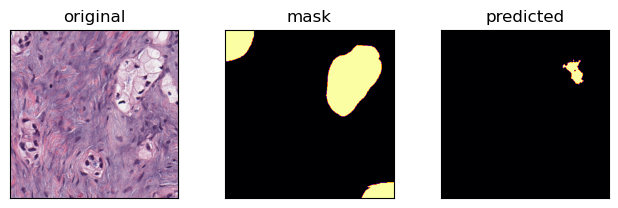

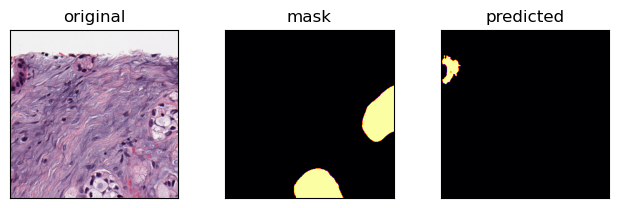

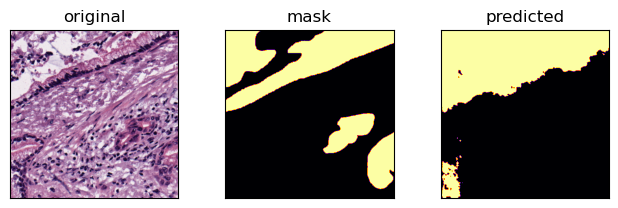

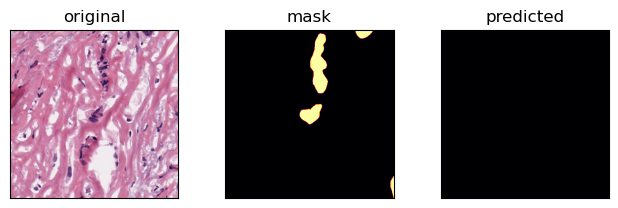

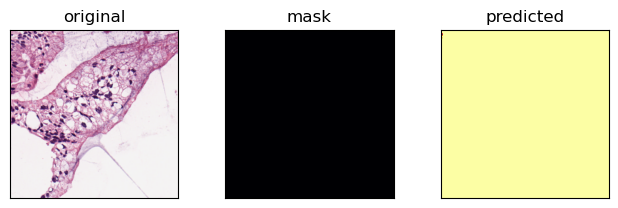

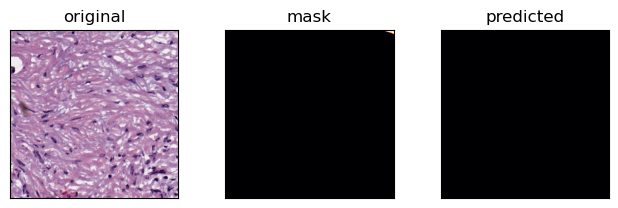

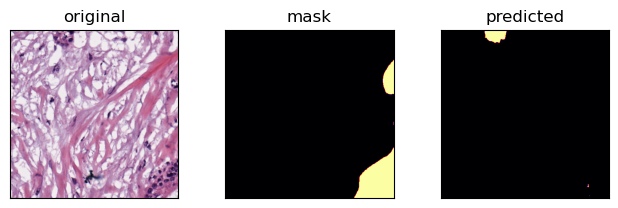

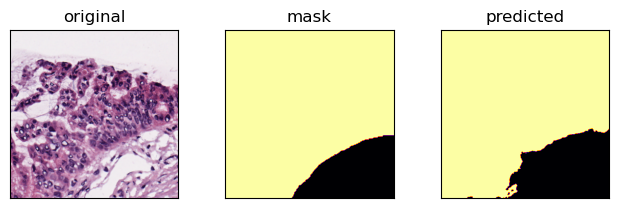

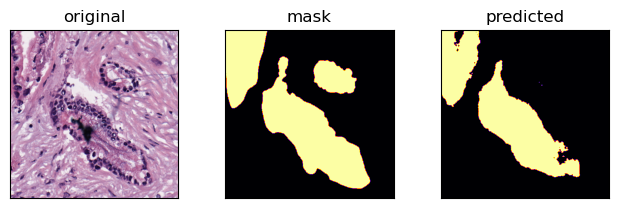

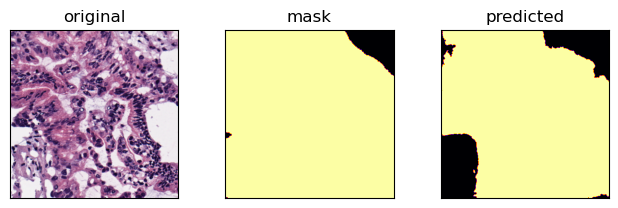

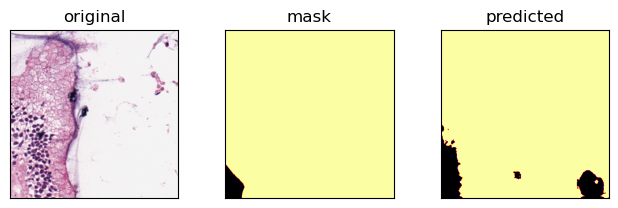

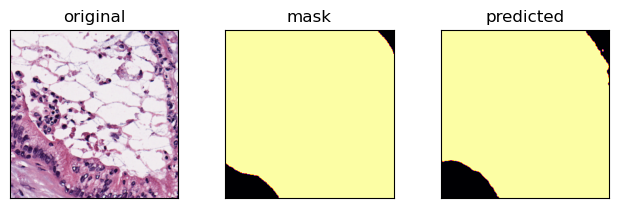

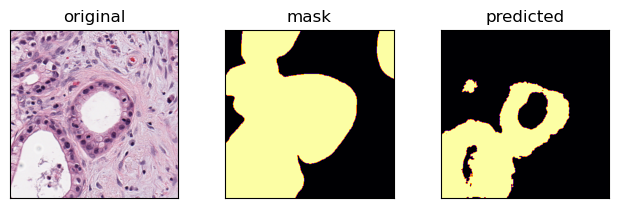

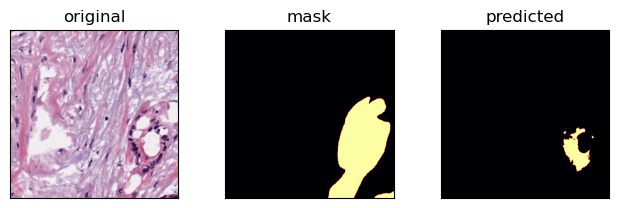

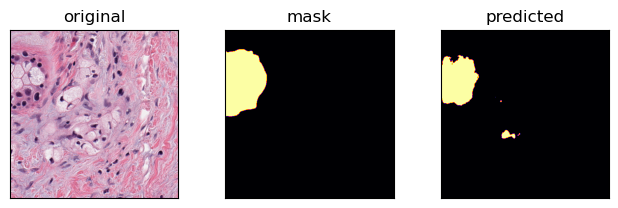

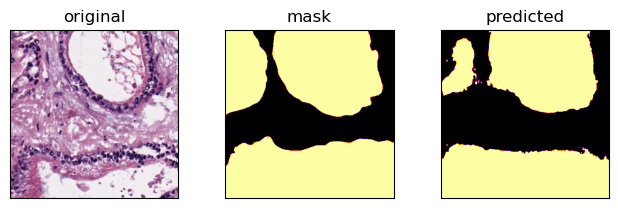

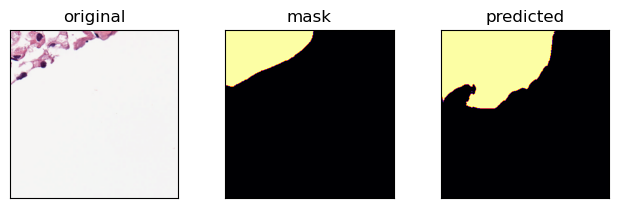

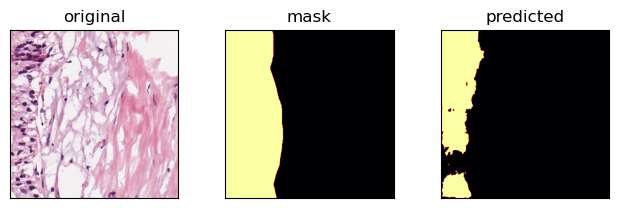

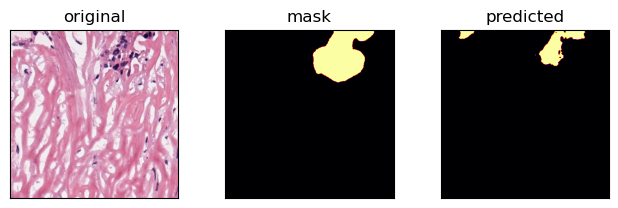

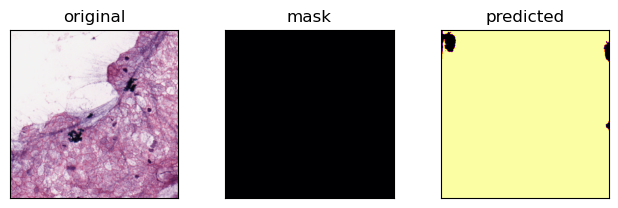

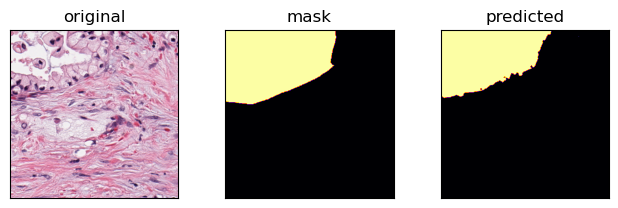

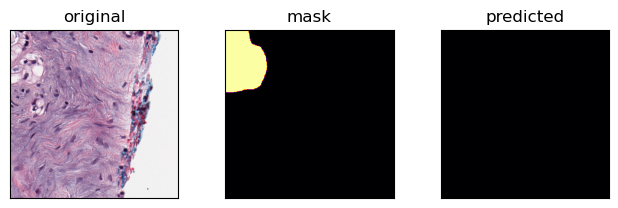

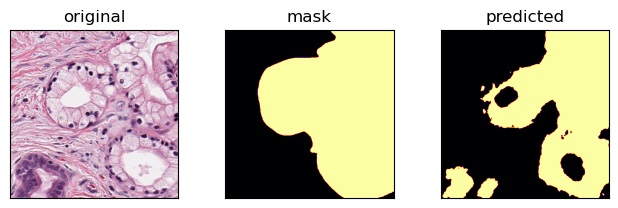

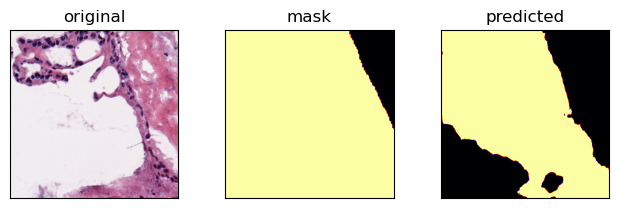

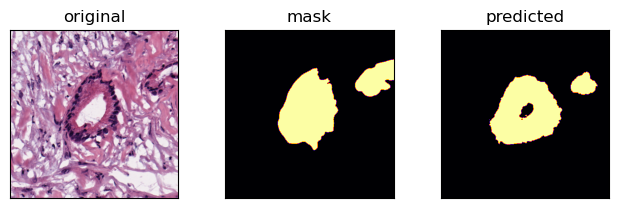

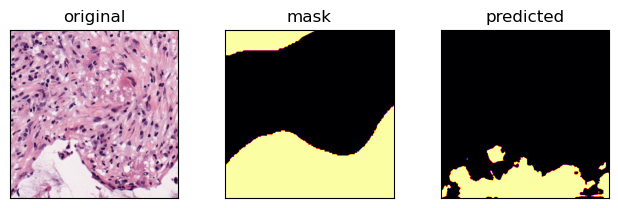

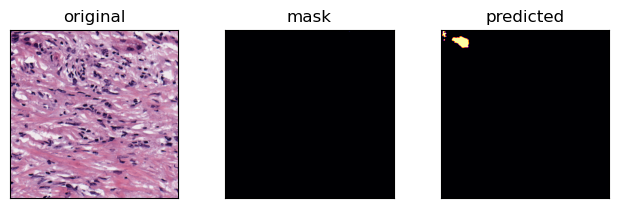

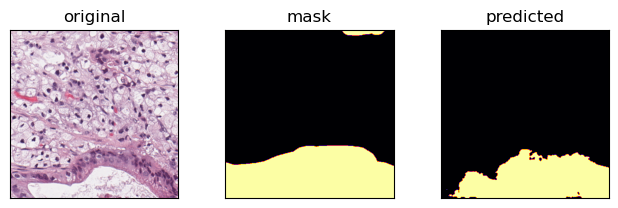

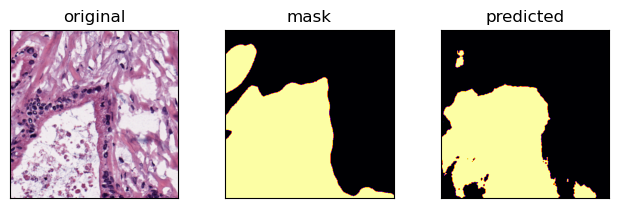

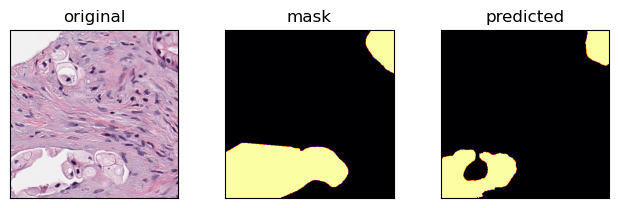

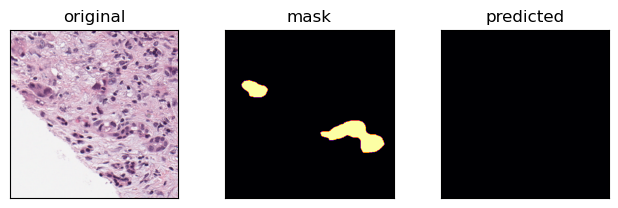

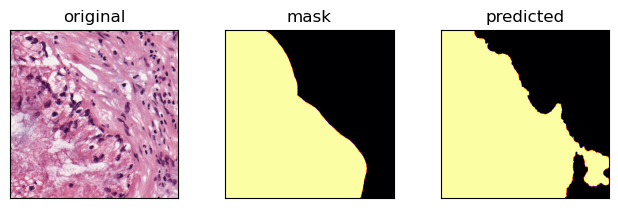

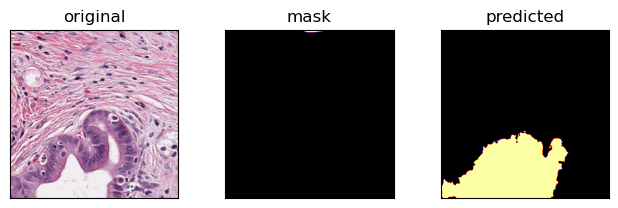

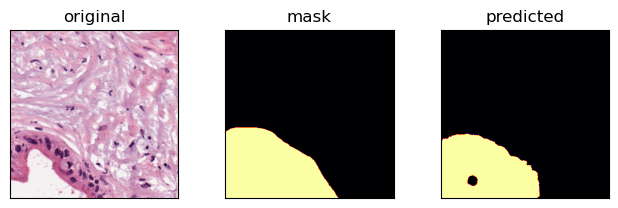

<Figure size 640x480 with 0 Axes>

In [36]:
# output_save
os.makedirs(output_path, exist_ok=True)

for i in range(50):   #len(tqdm(test_loader))
    
    data, label = test_set[i]
    label = torch.squeeze(label)

    with torch.no_grad():
        out = model(torch.unsqueeze(data, dim=0).to(device))
    out = torch.squeeze(out).sigmoid().to('cpu')
    pred = torch.ge(out, 0.5).float().to('cpu')

    # 오리지널 이미지
    plt.subplot(1,3,1)
    plt.title("original")
    plt.imshow(ToPILImage()(denormalize(data)))
    plt.xticks([]); plt.yticks([])

    # 마스크 이미지
    plt.subplot(1,3,2)
    plt.title("mask")
    plt.imshow(label)
    plt.xticks([]); plt.yticks([])
    
    # 마스크 예측 이미지
    plt.subplot(1,3,3)
    plt.title("predicted")
    plt.tight_layout()
    plt.imshow(pred)
    plt.xticks([]); plt.yticks([])

    plt.show()
    plt.savefig(f'{output_path}/{output_name}_{i+1}.png')